# Geodesic Example

First, we import the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

from fadge.metric import KerrSchild
from fadge.geode  import Geode
from fadge.utils  import Nullify

from jax          import numpy as np
from matplotlib   import pyplot as plt

We then create the `metric` and `nullify` functions, and the initial condition of a null geodesic.

In [2]:
metric  = KerrSchild(0.999)
nullify = Nullify(metric)

x = np.array([0,100,0,4.8])
v = nullify(x, np.array([1,1,0,0]))
s = np.concatenate([x, v])

Using these, we can create a geodesic precomputed from $\lambda = 0$ to $-200$.

In [3]:
geode = Geode(metric, 0, -200, s, full=True)

46it [00:01, 28.37it/s, x=-227, h=-62.1] 


We then pull the full DP5 step states, as well as creating interpolated data points.

In [4]:
l = np.linspace(0,-200,2001)
f = geode.ys
i = geode(l)

Here's the result from the full domain.  Note that, thanks to adaptive time stepping, the step size far away from the black hole is large.

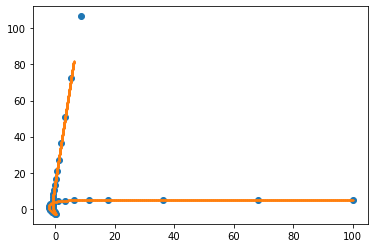

In [5]:
plt.scatter(f[:,1], f[:,3])
plt.scatter(i[:,1], i[:,3], s=1)

Zoomed-in

(-5.0, 5.0)

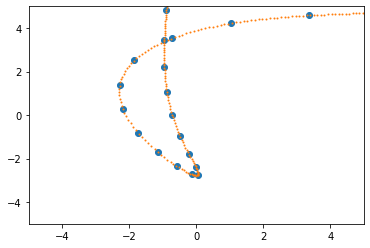

In [6]:
plt.scatter(f[:,1], f[:,3])
plt.scatter(i[:,1], i[:,3], s=1)
plt.xlim(-5,5)
plt.ylim(-5,5)